# Poster Data Processing

> please <strong>DO NOT</strong> try to run the code, since many of the function depends on my local files, which are not included here.

In [1]:
import math
import os
import io
import base64
import torch
import torchvision
import transformers

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image, HTML
from PIL import Image as PILImage
from io import BytesIO
from tqdm.notebook import tqdm

import sys
sys.path.append('/home/fxu/alignment/BLIP_Official')
from models.blip import blip_feature_extractor
from models.blip_itm import blip_itm

from transformers import AutoProcessor,AutoModel

from torchvision.transforms import v2
from load_poster_data import load_data

from torchmetrics.functional.pairwise import pairwise_cosine_similarity

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from openpyxl import Workbook
from openpyxl.drawing.image import Image as OpenpyxlImage
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
topics=[
    'nuclear accidents',
    'nuclear waste',
    'environmentalism'
]
poster_path='./posters_with_texts.pt'
poster_n_texts=torch.load(poster_path)
print(poster_n_texts.keys())
print(len(poster_n_texts['texts']))

dict_keys(['images', 'texts'])
59


## Group posters by year

In [5]:
dates=[]
for text in poster_n_texts['texts']:
    date=text.split(';')[1][-6:].strip('(').strip(')')
    dates.append(date)

cnts=[]
for date in sorted(set(dates)):
    cnt=dates.count(date)
    cnts.append(cnt)
    print(f'{date} has {cnt} posters.')
    
idx=[]
for i in range(len(dates)):
    if dates[i]=='1979' or dates[i]=='1984':
        idx.append(i)
print('All the selected indices of posters and corresponding text ',idx)

1974 has 1 posters.
1975 has 3 posters.
1979 has 18 posters.
1981 has 4 posters.
1982 has 1 posters.
1983 has 1 posters.
1984 has 11 posters.
1985 has 2 posters.
1986 has 2 posters.
1988 has 1 posters.
1990 has 3 posters.
1999 has 1 posters.
2003 has 8 posters.
2006 has 1 posters.
2010 has 1 posters.
2011 has 1 posters.
All the selected indices of posters and corresponding text  [6, 7, 8, 9, 13, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


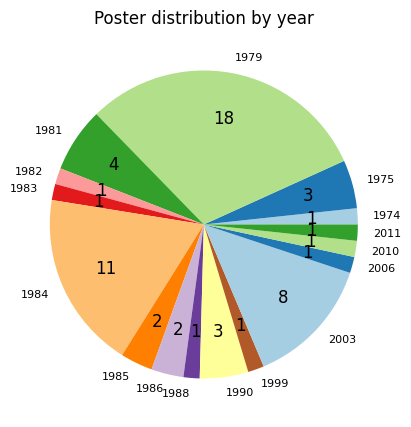

In [6]:
fig, ax = plt.subplots(figsize=(5,5))

dates=sorted(set(dates))

colors=plt.get_cmap('Paired').colors
wedges, texts=ax.pie(cnts,labels=dates,colors=colors,textprops={'fontsize': 8})

for i, txt in enumerate(cnts):
    # Get the center position of each wedge to place text
    angle = (wedges[i].theta2 - wedges[i].theta1) / 2. + wedges[i].theta1
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    
    # Place the text with a small offset to move it towards the center
    plt.text(x * 0.7, y * 0.7, txt, ha='center', va='center', fontsize=12)

ax.set_title('Poster distribution by year')

plt.savefig('./poster_distribution.pdf')

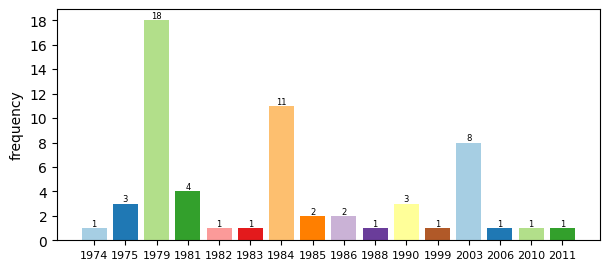

In [7]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(7,3))

bars=ax.bar(dates,cnts,color=colors)
ax.set_xticklabels(dates, fontsize=8)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', 
            ha='center', va='bottom', fontsize=6)

ax.set_ylabel('frequency')
#ax.set_title('Poster distribution by year')

plt.savefig('./poster_barplot.pdf')

In [8]:
imgs=[]
titles=[]
for j in idx:
    imgs.append(poster_n_texts['images'][j])
    titles.append(poster_n_texts['texts'][j])

In [9]:
transforms1 = v2.Compose([
    lambda img: img[:,:,:3] if img.size(2)==4 else img,
    lambda img: torch.cat((img,img,img),dim=0) if img.size(2)==1 else img,
    lambda img: img/256 if img.dtype!=torch.float else img,
    lambda img: img.permute(2,0,1),
    v2.Resize(size=(224, 224), antialias=True)
])

def text_process(title,line_length=4):
    words=title.strip(' ').split(' ')
    res=''
    for i in range(len(words)):
        res+=words[i]
        if (i+1)%line_length==0:
            res+='\n'
        else:
            res+=' '
    res=res.strip(' ').strip('\n')
    return res

def plot_poster_with_title(imgs,titles,fig_name):
    total=len(imgs)
    n_col=5
    n_row=int(math.ceil(total/n_col))
    subplt_size=3

    fig,axes=plt.subplots(n_row,n_col,figsize=(n_col*subplt_size,n_row*subplt_size))

    for ii in range(n_row*n_col):
        i,j=ii//n_col,ii%n_col
        axes[i,j].axis('off')
        if ii<total: 
            img=imgs[ii]
            img=transforms1(img)
            img=img.permute(1,2,0)
            axes[i,j].imshow(img)
            axes[i,j].set_title(f"{text_process(titles[ii].split(';')[0])}",fontsize=8)
    plt.subplots_adjust(left=0.0, right=1.0, top=.97, bottom=0.0, wspace=0.0, hspace=0.3)
    plt.savefig(f'./{fig_name}.pdf')

### Plot posters with their description scraped from LAKA website

In [10]:
#plot_poster_with_title(imgs,titles,'init_scrape')

### Re-scraping poster data by year 1979 and 1984, and show them as in the plot, totalling 45 posters

In [11]:
in_file='swiss_poster_links.csv'
out_file='swiss_poster_data_n45.pt'

if os.path.exists(f'./{out_file}'):
    swiss_poster_n45=torch.load(f'./{out_file}')
else:
    swiss_poster_n45=load_data(in_file,out_file)

In [12]:
#plot_poster_with_title(swiss_poster_n45['images'],swiss_poster_n45['texts'],'rescrape')

### Extract poster image and description features using CLIP/BLIP/BLIP2

In [13]:
transforms2 = v2.Compose([
    lambda img: img[:,:,:3] if img.size(2)==4 else img,
    lambda img: torch.cat((img,img,img),dim=0) if img.size(2)==1 else img
])

@torch.no_grad
def feature_extractor(data,model):
    features={}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    txts=data['texts']
    if model.lower() == 'clip':
        imgs=list(map(transforms2,data['images']))
        features['image features'],features['text features']=clip_feature_extraction(imgs,txts,device)
    elif model.lower() == 'blip':
        imgs=list(map(transforms1,data['images']))
        features['image features'],features['text features']=blip_feature_extraction(imgs,txts,device)
    elif model.lower() == 'blip2':
        imgs=list(map(transforms2,data['images']))
        features['image features'],features['text features']=blip2_feature_extraction(imgs,txts,device)
        
    return features
    
def clip_feature_extraction(imgs,txts,device):
    model = AutoModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
    processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
    txt_inputs=processor(text=txts,return_tensors='pt',padding=True,truncation=True).to(device)
    img_inputs=processor(images=imgs,return_tensors='pt').to(device)
    txt_features=model.get_text_features(**txt_inputs)
    img_features=model.get_image_features(**img_inputs)

    return img_features,txt_features

def blip_feature_extraction(imgs,txts,device):
    n_dim_features=256
    model_url='https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    model = blip_itm(pretrained=model_url, image_size=224, vit='base').eval()
    model=model.to(device)
    
    img_features=torch.zeros(len(imgs),n_dim_features).to(device)
    txt_features=torch.zeros(len(imgs),n_dim_features).to(device)

    for i,pair in enumerate(zip(imgs,txts)):
        image=pair[0].unsqueeze(0).to(device)
        caption=pair[1]
        image_feature,text_feature = model(image, caption, match_head='itc')
        img_features[i,:]=image_feature.detach()
        txt_features[i,:]=text_feature.detach()

    return img_features,txt_features

def blip2_feature_extraction(imgs,txts,device):
    model = AutoModel.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
    txt_inputs=processor(text=txts,return_tensors='pt',padding=True,truncation=True).to(device)
    img_inputs=processor(images=imgs,return_tensors='pt').to(device)
    txt_features=model.get_text_features(**txt_inputs)
    img_features=model.get_image_features(**img_inputs)

    return img_features,txt_features

In [14]:
clip_feat_n45=feature_extractor(swiss_poster_n45,'clip')
blip_feat_n45=feature_extractor(swiss_poster_n45,'blip')

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


In [15]:
swiss_poster_n29={'images':imgs,'texts':titles}
clip_feat_n29=feature_extractor(swiss_poster_n29,'clip')
blip_feat_n29=feature_extractor(swiss_poster_n29,'blip')

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


### Plot heat maps

I plotted cosine heat maps for each scraped data of size 29 and of size 45, respectively, using both CLIP and BLIP. Features from BLIP2 do not work directly in our case since the model produces very high-dimensional feature vectors (matrices).

In [16]:
def plot_cosine(features):
    cos_sim=pairwise_cosine_similarity(features['image features'].cpu(),features['text features'].cpu())
    plt.figure(figsize=(3,3))
    plt.imshow(cos_sim)
    plt.title('Img&txt cosine similarity')

def plot_all_data(feat_list,subtitles):
    length=len(feat_list)
    subplt_size=3
    fig,axes=plt.subplots(1,length,figsize=(length*subplt_size,subplt_size))
    for i in range(length):
        features=feat_list[i]
        cos_sim=pairwise_cosine_similarity(features['image features'].cpu(),features['text features'].cpu())
        im=axes[i].imshow(cos_sim)
        axes[i].set_title(f'{subtitles[i]} cosine similarity',fontsize=10)
        axes[i].axis('off')
        cbar=plt.colorbar(im,ax=axes[i],fraction=0.0465,pad=0.02)
        cbar.ax.tick_params(rotation=55)
    plt.savefig(f"./{''.join(subtitles)}.pdf")

In [17]:
#plot_all_data([clip_feat_n29,clip_feat_n45,blip_feat_n29,blip_feat_n45],['clip 29','clip 45','blip 29','blip 45'])

In [18]:
#plot_all_data([clip_feat_n45,blip_feat_n45],['clip','blip'])

In [19]:
def compute_acc(features,task='img_acc'):
    sim=pairwise_cosine_similarity(features['image features'].cpu(),features['text features'].cpu())
    if task=='txt_acc':
        sim=torch.transpose(sim,0,1)
    for k in [1,5,10]:
        vals,ids=torch.topk(sim,k=k,dim=1)
        cnt=0
        for i in range(sim.size(0)):
            if i in ids[i]:
                cnt+=1
        acc=round(cnt/ids.size(0)*100,2)
        print(f'{task} for top {k}: {acc}')

In [20]:
compute_acc(clip_feat_n45)

img_acc for top 1: 31.11
img_acc for top 5: 71.11
img_acc for top 10: 77.78


In [21]:
compute_acc(blip_feat_n45)

img_acc for top 1: 40.0
img_acc for top 5: 62.22
img_acc for top 10: 75.56


In [22]:
compute_acc(clip_feat_n45,'txt_acc')

txt_acc for top 1: 22.22
txt_acc for top 5: 53.33
txt_acc for top 10: 71.11


In [23]:
compute_acc(blip_feat_n45,'txt_acc')

txt_acc for top 1: 31.11
txt_acc for top 5: 51.11
txt_acc for top 10: 80.0


Fromt the above plot, we see a diagnal pattern for both datasets using CLIP and BLIP, but it seems the dataset with 45 poster images are better than that of 29 posters due to clearer patterns.

## Generate captions for posters via BLIP and BLIP2

In [24]:
from transformers import AutoProcessor, BlipForConditionalGeneration, Blip2ForConditionalGeneration, InstructBlipProcessor, InstructBlipForConditionalGeneration
from models.blip import blip_decoder

def generate_cap(images,model):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images=list(map(transforms2,images))
    if model.lower()=='blip':
        gen_caps=gen_cap_via_blip(images,device)
    elif model.lower()=='blip2':
        gen_caps=gen_cap_via_blip2(images,device)
    elif model.lower()=='blip_lavis':
        gen_caps=gen_cap_via_blip_lavis(images,device)
    elif model.lower()=='instructblip':
        gen_caps=gen_cap_via_instructblip(images,device)
    else:
        raise Exception('No such a model.')
        
    return gen_caps

def gen_cap_via_clip(images,device):
    pass

def gen_cap_via_blip(images,device):
    gen_caps=[]
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
    model=model.to(device)

    for image in images:
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model.generate(**inputs,max_length=20)
        gen_text=processor.decode(outputs[0], skip_special_tokens=True)
        gen_caps.append(gen_text)
    return gen_caps

def gen_cap_via_blip2(images,device):
    gen_caps=[]
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",
                                                          #load_in_8bit=True,
                                                          device_map={"": 0},
                                                          torch_dtype=torch.float16)

    for image in images:
        inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs,max_length=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        gen_caps.append(generated_text)
    return gen_caps

def gen_cap_via_instructblip(images,device):
    gen_caps=[]
    model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b").to(device)
    processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")
    prompt='Write a short description for the image.'
    for image in images:
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
        generated_ids = model.generate(**inputs,max_length=50)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        gen_caps.append(generated_text)
    return gen_caps

def gen_cap_via_blip_lavis(images,device):
    gen_caps=[]
    model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    model = blip_decoder(pretrained=model_url, image_size=224, vit='base')
    model.eval()
    model = model.to(device)
        
    for image in images:
        with torch.no_grad():
            caption = model.generate(image.unsqueeze(0).to(device), sample=False, num_beams=3, max_length=20, min_length=5) 
            #caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
            gen_caps.append(caption[0])
    return gen_caps

### Generated captions for dataset of 29 posters using BLIP

In [25]:
blip_generated_caps_n29=generate_cap(swiss_poster_n29['images'],'blip')
#print(blip_generated_caps_n29)

### Generated captions for dataset of 29 posters using BLIP2

In [26]:
blip2_generated_caps_n29=generate_cap(swiss_poster_n29['images'],'blip2')
#print(blip2_generated_caps_n29)

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.08it/s]
Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


### Generated captions for dataset of 29 posters using InstructBLIP

In [27]:
instructblip_generated_caps_n29=generate_cap(swiss_poster_n29['images'],'instructblip')
#print(instructblip_generated_caps_n29)

Loading checkpoint shards: 100%|██████████████████| 4/4 [00:00<00:00,  6.04it/s]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Expanding inputs for image tokens in InstructBLIP should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your InstructBLIP model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in 

### Plot original posters with generated captions together

In [28]:
def plot_gen_caps(images,caps,model_names,line_length=4,fontsize=12):
    nrow=len(images)
    ncol=len(caps)+1
    sub_size=2
    fig,axes=plt.subplots(nrow,ncol,figsize=(ncol*sub_size,nrow*sub_size))
    for idx in range(1,ncol):
        axes[0,idx].set_title(f'{model_names[idx-1]}-generated text',c='blue')
    for i in range(nrow):
        for j in range(ncol):
            axes[i,j].axis('off')
            image=transforms1(images[i]).permute(1,2,0)
            if j==0:
                axes[i,j].imshow(image)
            else:
                axes[i,j].text(.5,.5,text_process(caps[j-1][i],line_length),ha='center',va='center',fontsize=fontsize)
    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, wspace=0.35, hspace=0.0)

In [29]:
caps=[blip_generated_caps_n29,blip2_generated_caps_n29,instructblip_generated_caps_n29]
model_names=['blip','blip2','instruct-blip']
#plot_gen_caps(swiss_poster_n29['images'],caps,model_names)

### Generated captions for dataset of 45 posters using BLIP

In [30]:
blip_generated_caps_n45=generate_cap(swiss_poster_n45['images'],'blip')
#print(blip_generated_caps_n45)

### Generated captions for dataset of 45 posters using BLIP2

In [31]:
blip2_generated_caps_n45=generate_cap(swiss_poster_n45['images'],'blip2')
#print(blip2_generated_caps_n45)

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:02<00:00,  1.34s/it]


### Generated captions for dataset of 45 posters using instructBLIP

In [32]:
instructblip_generated_caps_n45=generate_cap(swiss_poster_n45['images'],'instructblip')
#print(instructblip_generated_caps_n45)

Loading checkpoint shards: 100%|██████████████████| 4/4 [00:00<00:00,  5.98it/s]


In [33]:
caps=[blip_generated_caps_n45,blip2_generated_caps_n45,instructblip_generated_caps_n45]
#plot_gen_caps(swiss_poster_n45['images'],caps,model_names)

# Topic mathcing

In [34]:
def get_topics(topics):
    topic_set={'images':[torch.ones(224,224,3) for i in range(len(topics))],'texts':[f'a poster image of {topic}' for topic in topics]}
    return topic_set

In [35]:
# Step 3: Convert NumPy arrays to base64-encoded strings
def array_to_base64(array):
    pil_img = PILImage.fromarray(array)
    buffer = io.BytesIO()
    pil_img.save(buffer, format='PNG')
    byte_data = buffer.getvalue()
    base64_str = base64.b64encode(byte_data).decode('utf-8')
    return base64_str


# Step 4: Display the DataFrame with images inline
def path_to_image_html(base64_str,width=40, height=40):
    return f'<img src="data:image/png;base64,{base64_str}" width="{width}" height="{height}"/>'


def display_topics(df):
    #df.style.set_properties(subset=[df.columns[-1]],**{'text-align': 'left'})
    df['images'] = df['images'].apply(array_to_base64)
    
    pd.set_option('display.max_colwidth', None)
    html = df.to_html(escape=False, formatters={'images': path_to_image_html,
                                               f"{df.columns[-1]}": lambda x: f'<div style="text-align: right;">{x}</div>'
                                               })
    display(HTML(html))

### define visual concrete topics and abstract topics seperately

In [36]:
def plot_sim(topics,images,cosine):
    
    clip_topic_score=cosine.cpu().t()
    plt.figure(figsize=(18,4))
    plt.imshow(clip_topic_score)
    plt.yticks(range(len(topics)), topics, fontsize=12)
    plt.xticks([])
    for i, image in enumerate(images):
        plt.imshow(image,extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(clip_topic_score.shape[1]):
        for y in range(clip_topic_score.shape[0]):
            plt.text(x, y, f"{clip_topic_score[y, x]:.2f}", ha="center", va="center", size=8)
    
    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)
    
    plt.xlim([-0.5, len(images) - 0.5])
    plt.ylim([len(topics) + 0.5, -2])
    
    #plt.title("Cosine similarity between text and image features", size=14)
    plt.savefig('./')

In [37]:
def get_df(images,topics,model='clip'):
    topic_set=get_topics(topics)
    with torch.no_grad():
        embeddings=feature_extractor(topic_set,model.lower())
    data={'images':images,'texts':['']*len(images)}
    if model=='clip':
        img_features=feature_extractor(data,'clip')['image features']
    elif model=='blip':
        img_features=feature_extractor(data,'blip')['image features']
        
    cosine=pairwise_cosine_similarity(img_features,embeddings['text features'])
    vals,ids=torch.max(cosine,dim=1)
    
    nrow=len(images)
    ncol=len(topics)
    index=np.zeros((nrow,ncol),dtype=int)
    index[np.arange(nrow),ids.cpu().numpy()]=1

    clip_dict={'images':[img.numpy() for img in images]}
    for i in range(ncol):
        clip_dict[f'{topics[i]}']=index[:,i]

    clip_df=pd.DataFrame(clip_dict)

    plot_sim(topics,images,cosine)
    
    return clip_df

In [38]:
images=swiss_poster_n45['images']
texts=swiss_poster_n45['texts']

### Topics matching score for all visual topics using CLIP

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


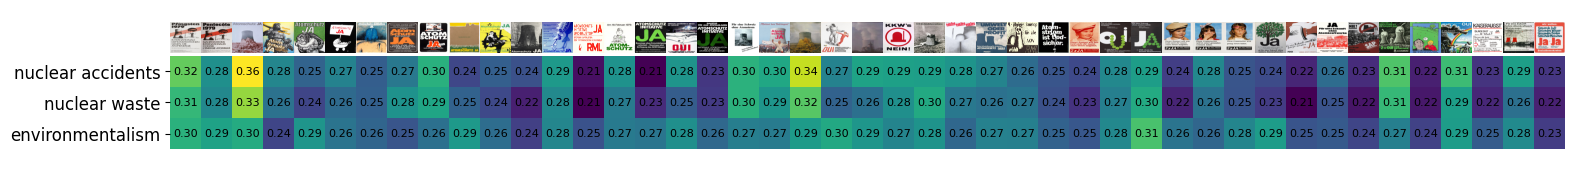

In [39]:
clip_visual_df=get_df(images,topics)

### Top 1 visual topic for each image using CLIP

In [40]:
#display_topics(clip_visual_df)

### Topics matching score for all visual topics using BLIP

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


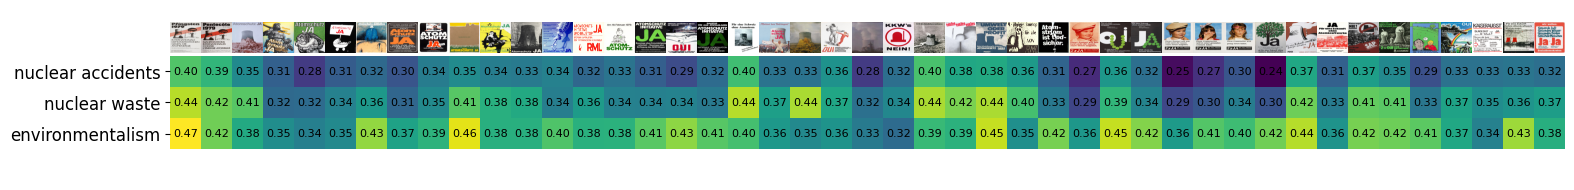

In [41]:
blip_visual_df=get_df(images,topics,'blip')

### Top 1 visual topic for each image using BLIP

In [42]:
#display_topics(blip_visual_df)

In [43]:
def pixels_to_excel_width(pixels):
    # Column width in Excel is roughly 1/7th of a pixel
    return pixels / 7

def pixels_to_excel_height(pixels):
    # Row height in Excel is roughly 0.75 pixels per height unit
    return pixels * 0.75

data = {
    "image": [None]*len(images),
    "text":list(map(lambda t: t.split(';')[0],texts))
}
for topic in topics:
    data[topic]=np.zeros((len(images),),dtype=int)

data['real_image']=images

df = pd.DataFrame(data)

# Create a new Excel workbook and select the active worksheet
wb = Workbook()
ws = wb.active

for r_idx, r in enumerate(dataframe_to_rows(df.drop(columns=["real_image"]), index=False, header=True), start=1):
    ws.append(r)
    
    # Center align all cells in the current row
    for col_idx, _ in enumerate(r, start=1):
        cell = ws.cell(row=r_idx, column=col_idx)
        cell.alignment = Alignment(horizontal='center', vertical='center')
        
# Directory to store temporary image files
temp_dir = "./temp_images"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Insert images into the corresponding cells
for index, row in df.iterrows():
    # Convert NumPy array to an image using PIL
    img_array = row["real_image"]
    img_pil = PILImage.fromarray(img_array.numpy())
    img_pil.thumbnail((90,90))
    
    # Save the image to a temporary file
    img_path = os.path.join(temp_dir, f'image_{index}.png')
    img_pil.save(img_path)
    
    # Insert the image into the Excel file at the correct cell
    img_excel = OpenpyxlImage(img_path)
    cell = f'A{index + 2}'  # Adjust cell location (column 'B' for images, starting at row 2)
    ws.add_image(img_excel, cell)

    img_width, img_height = img_pil.size  # In pixels
    
    # Adjust row height (row index starts from 2 for data rows)
    ws.row_dimensions[index + 2].height = pixels_to_excel_height(img_height)
    
    # Adjust column width (column A for images)
    ws.column_dimensions['A'].width = pixels_to_excel_width(img_width)

# Save the workbook to an Excel file
wb.save("data_with_images_from_numpy.xlsx")

# Optionally, clean up temporary image files

for file in os.listdir(temp_dir):
    os.remove(os.path.join(temp_dir, file))
os.rmdir(temp_dir)

In [44]:
poster_annotation=pd.read_excel('./poster_anno.xlsx')

In [45]:
poster_annotation=poster_annotation.fillna(0)
poster_annotation[['children','environment']]=poster_annotation[['children','environment']].astype('int64')
poster_indices=poster_annotation[poster_annotation['doom']!=1].index.tolist()

In [46]:
clean_images=[]
clean_texts=[]
for idx in poster_indices:
    clean_images.append(swiss_poster_n45['images'][idx])
    clean_texts.append(swiss_poster_n45['texts'][idx])

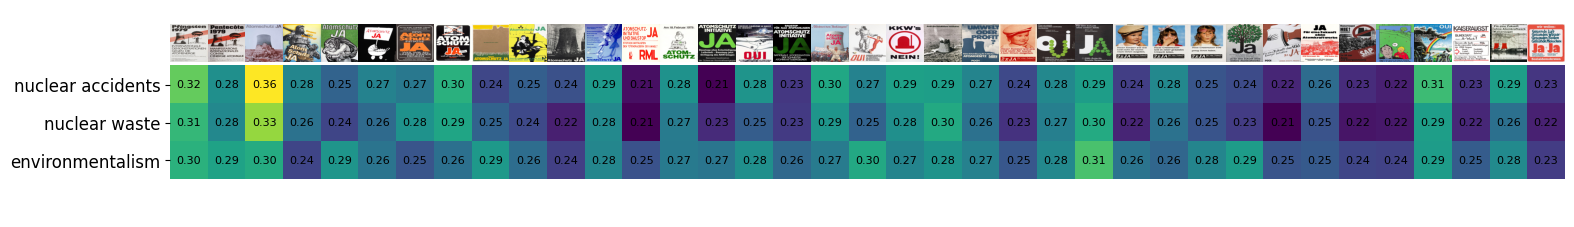

In [47]:
clean_clip_df=get_df(clean_images,topics)

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


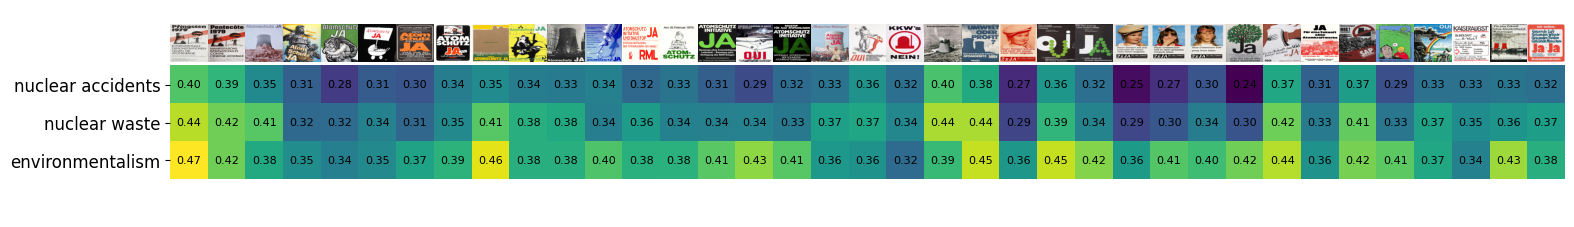

In [48]:
clean_blip_df=get_df(clean_images,topics,'blip')

# Clustering Posters

Here I use clustering methods to visulize the data distribution with their text description, so that you can get a better idea of how to form topics based on such distribution. To reduce the dimensionality of poster images, I resize all the images to same size of (224,224), and then flatten the resized images to single vectors via concatenating all channels. After that, dimension reduction methods are applied. Note the dimensionality reduction is not based on extracted image features but the original images.

### Using UMAP

In [38]:
import umap.umap_ as umap

def reduce_data(list_of_imgs,reducer):
    transforms3 = v2.Compose([
        lambda img: img[:,:,:3] if img.size(2)==4 else img,
        lambda img: torch.cat((img,img,img),dim=0) if img.size(2)==1 else img,
        lambda img: img.permute(2,0,1),
        v2.Resize(size=(224, 224), antialias=True),
        lambda img: img.flatten().unsqueeze(0)
    ])
    
    data=torch.cat(list(map(transforms3,list_of_imgs)),dim=0)
    reduced_data=reducer.fit_transform(data)
    return reduced_data

In [39]:
n29_umap=reduce_data(swiss_poster_n29['images'],umap.UMAP(random_state=0))

In [42]:
#plt.scatter(n29_umap[:,0],n29_umap[:,1])

Visualize the reduced poster images via UMAP, but the results seems to be uninformative. I therefore discard this method for convinience.

### Using t-SNE

In [41]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,
          random_state=0,
          perplexity=3)
n29_tsne=reduce_data(swiss_poster_n29['images'],tsne)
n45_tsne=reduce_data(swiss_poster_n45['images'],tsne)

In [42]:
def plot_reduced_data(reduced_data,texts):
    xs,ys=reduced_data[:,0],reduced_data[:,1]
    plt.figure(figsize=(10,10),dpi=224)
    plt.scatter(xs,ys)
    anatations=list(map(text_process,texts))
    for i in range(len(texts)):
        plt.annotate(anatations[i].split(';')[0],(xs[i],ys[i]),fontsize=4,ha='center',va='center')
    plt.title('Poster distribution with the corresponding text')

def plot_miniatures(reduced_data,imgs):
    xs,ys=reduced_data[:,0],reduced_data[:,1]
    fig,ax=plt.subplots(figsize=(10,10),dpi=100)
    ax.scatter(xs,ys)
    for i in range(len(imgs)):
        miniature=AnnotationBbox(OffsetImage(imgs[i], zoom=.06), (xs[i], ys[i]), frameon=False)
        ax.add_artist(miniature)
    plt.title('Poster distribution')

In [43]:
#plot_reduced_data(n29_tsne,swiss_poster_n29['texts'])

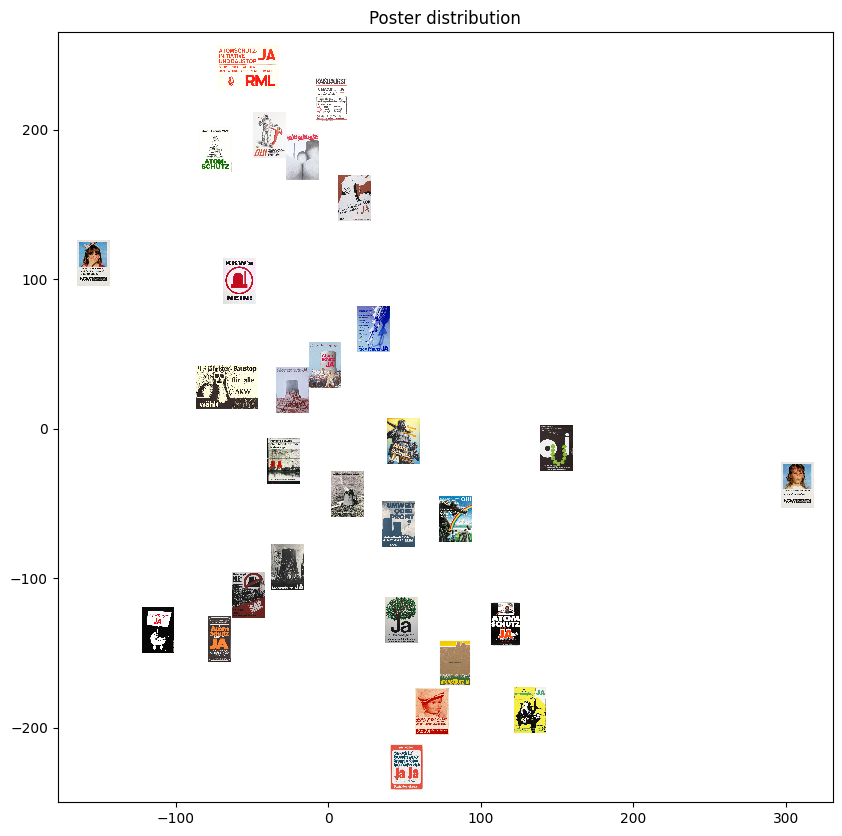

In [44]:
plot_miniatures(n29_tsne,swiss_poster_n29['images'])

This plot show the poster distribution of the 29-poster dataset.

In [44]:
#plot_reduced_data(n45_tsne,swiss_poster_n45['texts'])

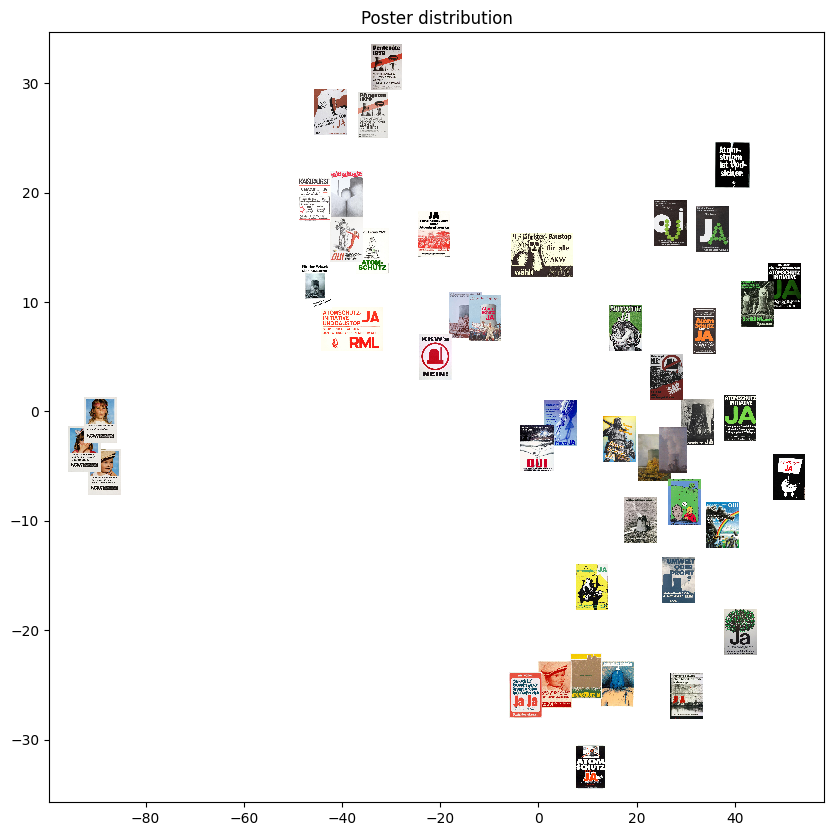

In [46]:
plot_miniatures(n45_tsne,swiss_poster_n45['images'])

This one exhibit the distribution of re-scraped 45 posters.

## Cluster images and texts based on features extracted by CLIP/BLIP

### CLIP features for 29 posters and 45 posters respectively

In [47]:
def show_img_based_on_features(feat,group,base='img'):
    if base=='img':
        reduced_feat=tsne.fit_transform(feat['image features'].cpu())
        plot_miniatures(reduced_feat,group['images'])
    elif base=='txt':
        reduced_feat=tsne.fit_transform(feat['text features'].cpu())
        plot_miniatures(reduced_feat,group['images'])

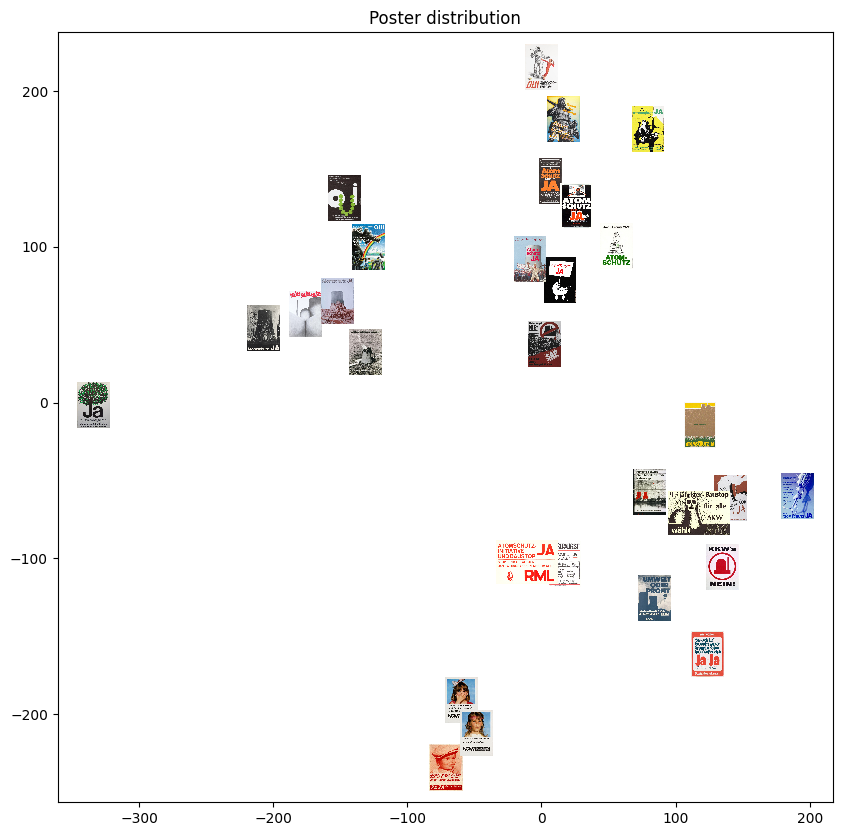

In [48]:
show_img_based_on_features(clip_feat_n29,swiss_poster_n29,'img')

The above is the 29-poster-image distribution based on reduced clip image features using t-SNE.

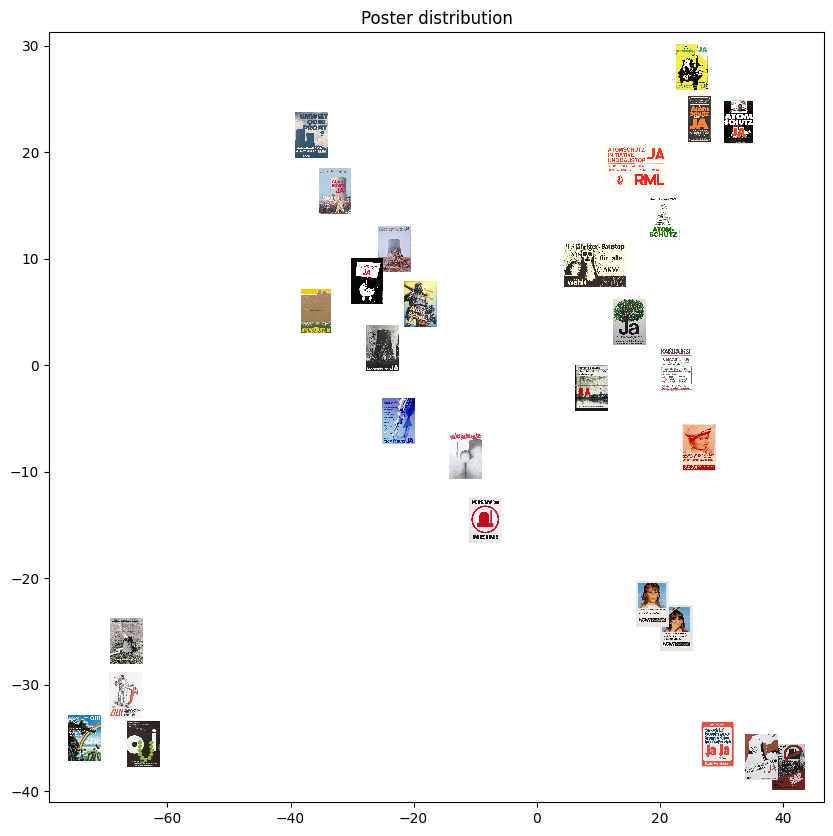

In [49]:
show_img_based_on_features(clip_feat_n29,swiss_poster_n29,'txt')

The above is the 29-poster-image distribution based on reduced clip text features using t-SNE.

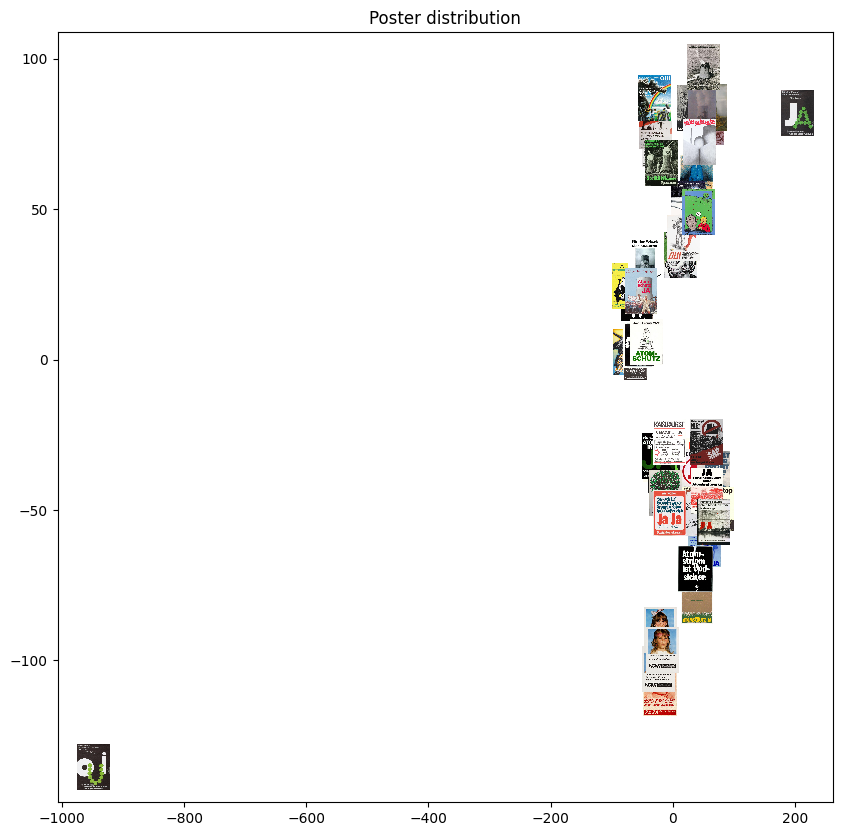

In [50]:
show_img_based_on_features(clip_feat_n45,swiss_poster_n45,'img')

The above is the 45-poster-image distribution based on reduced clip image features using t-SNE.

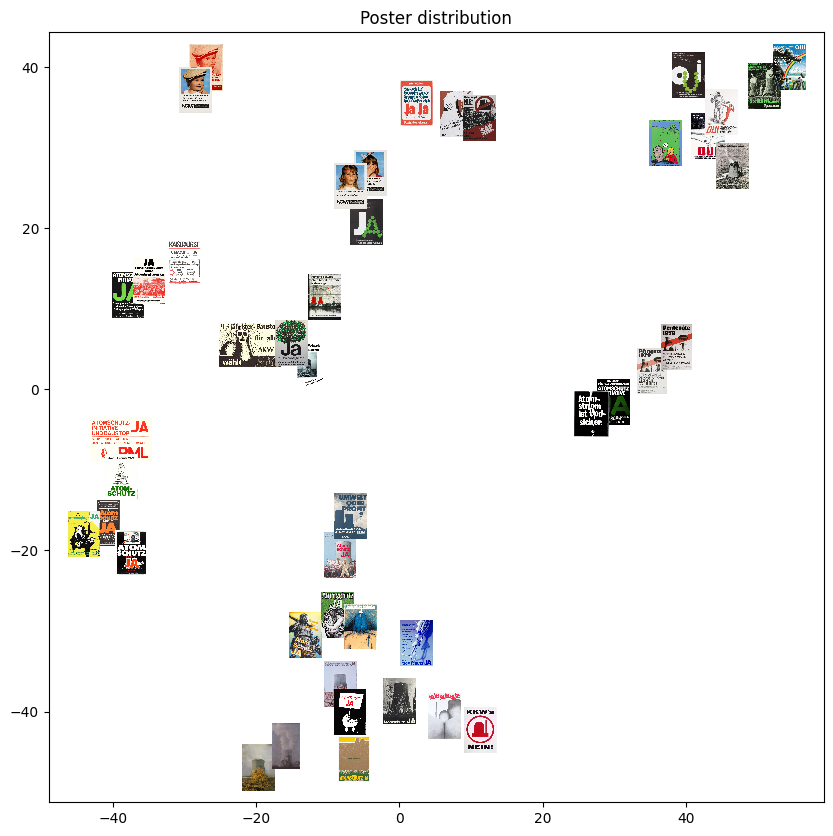

In [51]:
show_img_based_on_features(clip_feat_n45,swiss_poster_n45,'txt')

The above is the 45-poster-image distribution based on reduced clip text features using t-SNE.

### BLIP features for 29 posters and 45 posters respectively

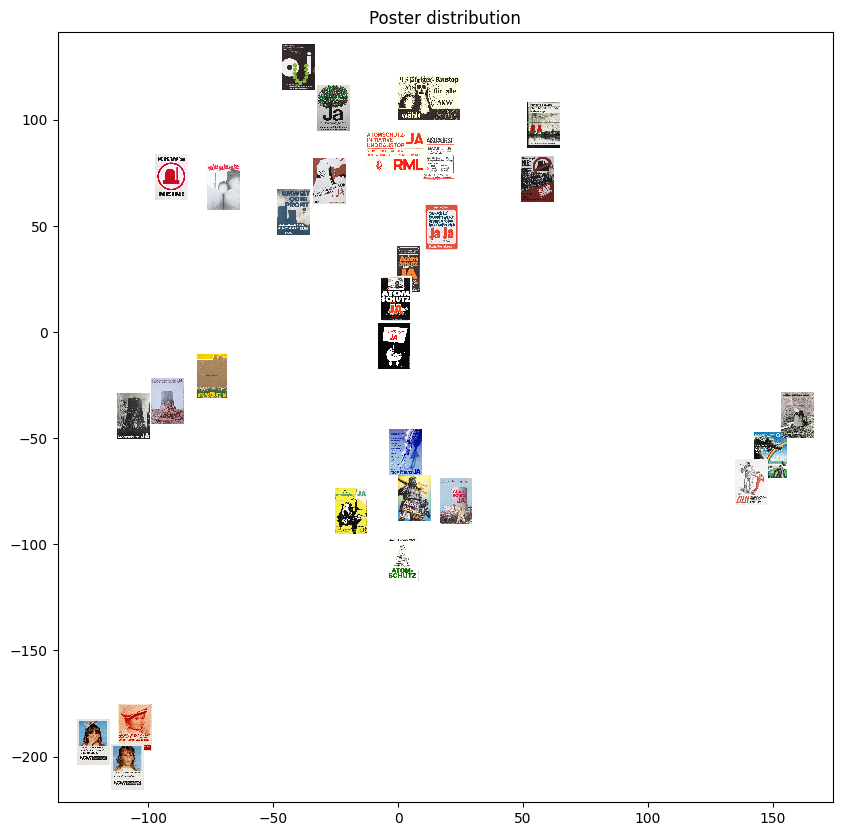

In [52]:
show_img_based_on_features(blip_feat_n29,swiss_poster_n29,'img')

The above is the **29**-poster-image distribution based on reduced **blip image** features using t-SNE.

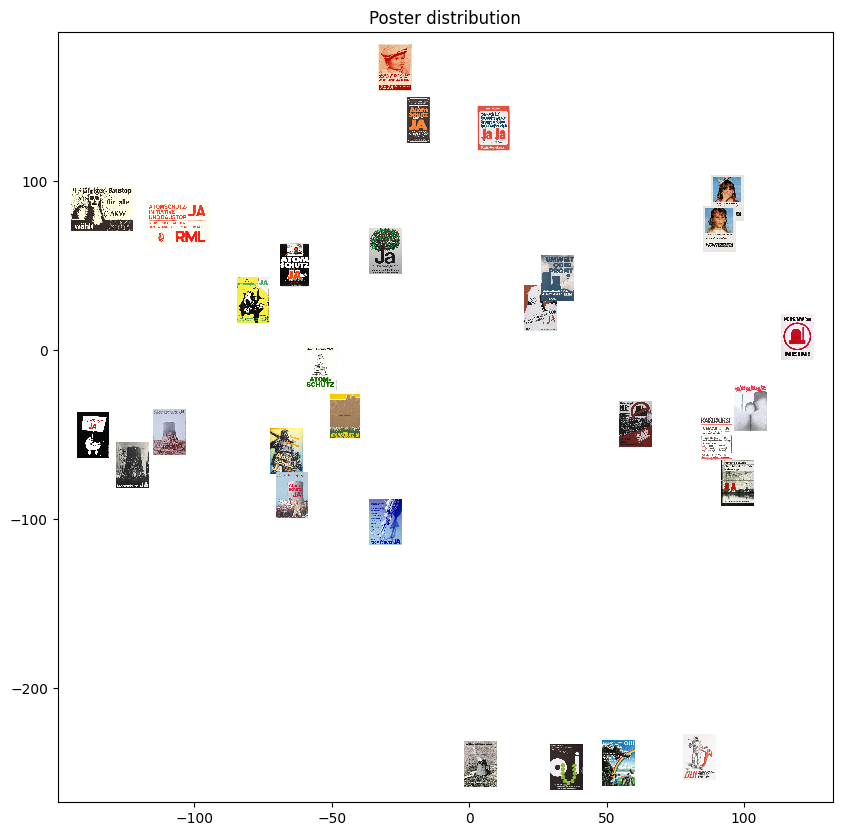

In [53]:
show_img_based_on_features(blip_feat_n29,swiss_poster_n29,'txt')

The above is the **29**-poster-image distribution based on reduced **blip text** features using t-SNE.

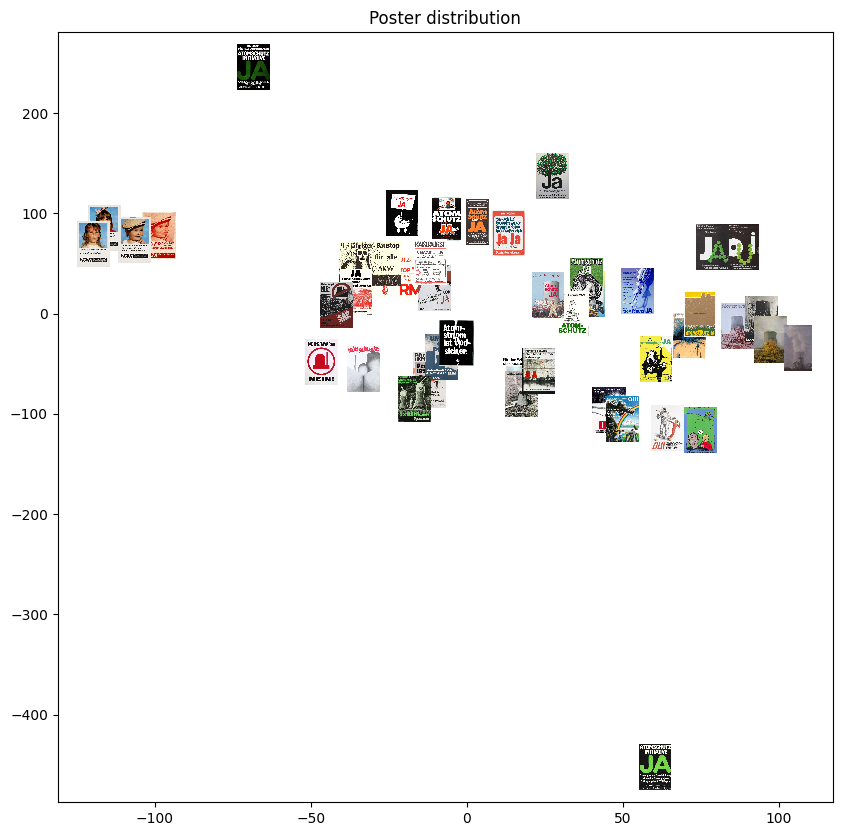

In [54]:
show_img_based_on_features(blip_feat_n45,swiss_poster_n45,'img')

The above is the **45**-poster-image distribution based on reduced **blip image** features using t-SNE.

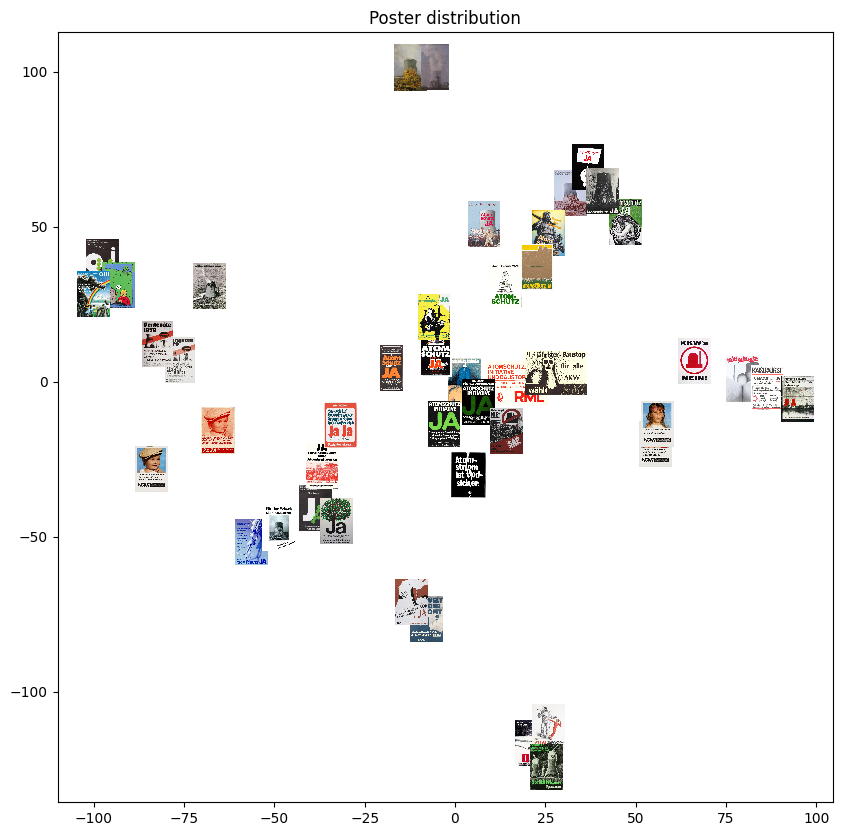

In [55]:
show_img_based_on_features(blip_feat_n45,swiss_poster_n45,'txt')

The above is the **45**-poster-image distribution based on reduced **blip text** features using t-SNE.

## Text Processing

### Bag of Words (BoW)

In [15]:
def get_contents(topics):
    article_dfs=[]
    article_related=[]
    article_unrelated=[]
    title_related=[]
    title_unrelated=[]
    for topic in topics:
        if topic=='environmentalism':
            df_related=pd.read_csv('./impresso/environ_related.csv',sep=';',header=0)
            df_unrelated=pd.read_csv('./impresso/environ_unrelated.csv',sep=';',header=0)
        elif topic=='nuclear accidents':
            df_related=pd.read_csv('./impresso/accidents_related.csv',sep=';',header=0)
            df_unrelated=pd.read_csv('./impresso/accidents_unrelated.csv',sep=';',header=0)
        elif topic=='nuclear waste':
            df_related=pd.read_csv('./impresso/waste_related.csv',sep=';',header=0)
            df_unrelated=pd.read_csv('./impresso/waste_unrelated.csv',sep=';',header=0)
        else:
            raise Exception('No such topic!')
        df_related=df_related.drop(columns=['title.1','content.1'],inplace=False)
        df_unrelated=df_unrelated.drop(columns=['title.1','content.1'],inplace=False)
        article_dfs.append(df_related)
        article_dfs.append(df_unrelated)
        
        article_related.append(df_related['content'].tolist())
        article_unrelated.append(df_unrelated['content'].tolist())
        
        title_related.append(df_related['title'].tolist())
        title_unrelated.append(df_unrelated['title'].tolist())
    return article_dfs,article_related+article_unrelated,title_related+title_unrelated

In [53]:
method=CountVectorizer()
query = ['Unfall','Abfall','Umweltschutz, Waldsterben']
corpus=article_related+article_unrelated

def compute_precision(method,query,corpus):
    vectorizer = method
    X = vectorizer.fit_transform(corpus)
    document_term_matrix = X.toarray()
    
    query_vector = vectorizer.transform(query).toarray()
    
    similarity_scores = cosine_similarity(query_vector, document_term_matrix)
    
    for i in range(len(query)):
        start=sum(cnt_related[:i])
        end=sum(cnt_related[:i+1])
        curr_range=range(1,document_term_matrix.shape[0])[start:end]
        ranked_indices = np.argsort(similarity_scores[i])[::-1]  # Sort indices in descending order
    
        cnt=0
        print('current range:',curr_range)
        for idx in ranked_indices[:len(curr_range)]:
            print(f"Article {idx + 1} with score {similarity_scores[i][idx]:.4f}")
            if idx+1 in curr_range:
                cnt+=1
        acc=cnt/len(curr_range)
        print(f"Precision: {acc*100:.2f}%")

current range: range(1, 12)
Article 44 with score 0.2485
current range: range(1, 12)
Article 7 with score 0.2041
current range: range(1, 12)
Article 49 with score 0.1726
current range: range(1, 12)
Article 3 with score 0.1682
current range: range(1, 12)
Article 4 with score 0.1374
current range: range(1, 12)
Article 5 with score 0.1322
current range: range(1, 12)
Article 38 with score 0.1245
current range: range(1, 12)
Article 42 with score 0.1147
current range: range(1, 12)
Article 6 with score 0.1051
current range: range(1, 12)
Article 10 with score 0.1009
current range: range(1, 12)
Article 50 with score 0.0960
Precision: 54.55%
current range: range(12, 22)
Article 60 with score 0.2009
current range: range(12, 22)
Article 61 with score 0.1706
current range: range(12, 22)
Article 55 with score 0.1390
current range: range(12, 22)
Article 57 with score 0.1239
current range: range(12, 22)
Article 58 with score 0.0921
current range: range(12, 22)
Article 62 with score 0.0815
current rang

In [72]:
model_id_3_1 = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id_3_2 = "meta-llama/Llama-3.2-3B-Instruct"
model_ids=[model_id_3_1,model_id_3_2]

In [89]:
system_role_translator="You are a professional translator in German language.\
            I will give you some articles, and you need to translate them from German to English.\
            Note the German article might contain some typos or errors, you must do as a professional translator in such cases.\
            Plus, please remove unnecessary symbols such as line breaks, paragraph breaks, spaces, and tabs, etc.\
            Only output translated articles."
system_role_editor="You are a professional editor in German language.\
            I will give you some articles, and you need to correct the errors or typos according to the context in the article.\
            Plus, please remove unnecessary symbols such as line breaks, paragraph breaks, spaces, and tabs, etc.\
            Only output the article after correction."

def manipulate_articles(model_id,system_role,articles):
    results=[]
    
    pipeline= transformers.pipeline(
        "text-generation",
        model=model_id,
        model_kwargs={"torch_dtype": torch.bfloat16},
        device_map="auto",
    )
    for article in articles:
        messages = [
            {"role": "system", "content": system_role},
            {"role": "user", "content": article},
        ]
        outputs = pipeline(
            messages,
            max_new_tokens=3076
        )
        results.append(outputs[0]["generated_text"][-1]['content'])
    return results

In [10]:
_,articles,titles=get_contents()

In [14]:
for i in range(len(articles)):
    print(len(articles[i]))

11
10
11
21
12
20
